In [1]:
import sys
sys.path.append('/home/kyungtak.lim/gbspy')
#from skimage.measure import label, regionprops

In [2]:
import gbspy as g
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py

import multiprocessing as mp
from matplotlib.animation import FuncAnimation
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
import matplotlib.lines as mlines
from matplotlib.ticker import AutoMinorLocator
import matplotlib.colors as mcolors

#import sys  
#sys.path.insert(0, '/marconi/home/userexternal/klim0000/miniconda3/lib/python3.9/site-packages/gbs_python/gbspy')

In [4]:
# IEEE journals typically require figures to be very clear at a column width of around 3.5 to 4 inches
fig_width = 3.5  # in inches
fig_height =  fig_width / 1.618
plt.rcParams.update({
    # Figure size and DPI
    'figure.figsize': (fig_width, fig_width / 1.618),  # IEEE column width, golden ratio height
    'figure.dpi': 300,                     # Figure resolution
    'savefig.dpi': 300,                    # Save figure resolution
    'savefig.format': 'pdf',               # Preferred format for vector graphics

    # Font settings
    'font.size': 10,                       # Main font size
    #'font.family': 'Sans-serif',           # Font family
    #'font.sans-serif': ['Arial', 'Helvetica'],  # Font type

    # Axes settings
    'axes.labelsize': 10,                  # Font size of the x and y labels
    'axes.titlesize': 10,                  # Font size of the title
    'axes.linewidth': 1,                   # Edge line width

    # Tick settings
    'xtick.labelsize': 10,                  # Font size of the x tick labels
    'ytick.labelsize': 10,                  # Font size of the y tick labels
    'xtick.major.size': 4,                 # Length of major tick marks
    'xtick.minor.size': 2,                 # Length of minor tick marks
    'xtick.major.width': 1,                # Width of major tick marks
    'xtick.minor.width': 0.5,              # Width of minor tick marks
    'ytick.major.size': 4,                 # Length of major tick marks
    'ytick.minor.size': 2,                 # Length of minor tick marks
    'ytick.major.width': 1,                # Width of major tick marks
    'ytick.minor.width': 0.5,              # Width of minor tick marks

    # Legend settings
    'legend.fontsize': 12,                  # Font size of the legend
    'legend.frameon': True,               # Disable background frame
    'legend.edgecolor':'white',

    # Line settings
    'lines.linewidth': 1.5,                # Line width
    'lines.markersize': 4,                 # Marker size
    'lines.markeredgewidth' : 0.8,
    'lines.markeredgecolor' : 'black',
    # Grid settings
    'grid.alpha': 0.5,                     # Grid line transparency
    'grid.linestyle': ':',                 # Grid line style
    
    # Scatter settings
    #'scatter.edgecolors': None,
    
    # Marker
    'lines.markeredgewidth' : 5,
    'lines.markeredgecolor' : 'black'

})

<div class="alert alert-block alert-info" style="text-align: center;">
<span style="font-size: 20px;"><b> Data load</b></span><br>
</div>

In [5]:
# Get the current working directory|
cwd = os.getcwd()

os.chdir('/zhisongqu_data/kyungtak/data_GBS/GBS_SN/nu_scan/SN_nu0p01')
print("Current working directory: {0}".format(cwd))

# Load GBS simulations
s=g.Sim()

t2= s.time[-1]
t1= t2

# Entire torus
z1 = s.z[0]
z2 = s.z[-1]
iz = s.find_ind(z2, s.z)
bsign = s.attribute["B0sign"]

Psi = s.Psi; ixxpt = s.ixxpt; iyxpt = s.iyxpt

dens  = s.get_field('n', z1=z1, z2=z2, t1=t1, t2=t2)
dens_avg  = np.mean(dens, axis=(2,3)); 
dens_std  = np.std(dens, axis=(2,3))
dens_avg_tor = np.mean(dens, axis=2)

# Normalized
dens_fluct   = np.sqrt((dens[:,:,0,:]-dens_avg_tor)**2) / dens_avg_tor
#dens_fluct = dens[:,:,0,-1] - dens_avg
dens_fluct_avg = np.mean(dens_fluct, axis=2)


Current working directory: /home/kyungtak.lim/Jupyter_notebook_GBS/Abhiram


<div class="alert alert-block alert-info" style="text-align: center;">
<span style="font-size: 20px;"><b> Blob detection </b></span><br>
</div>

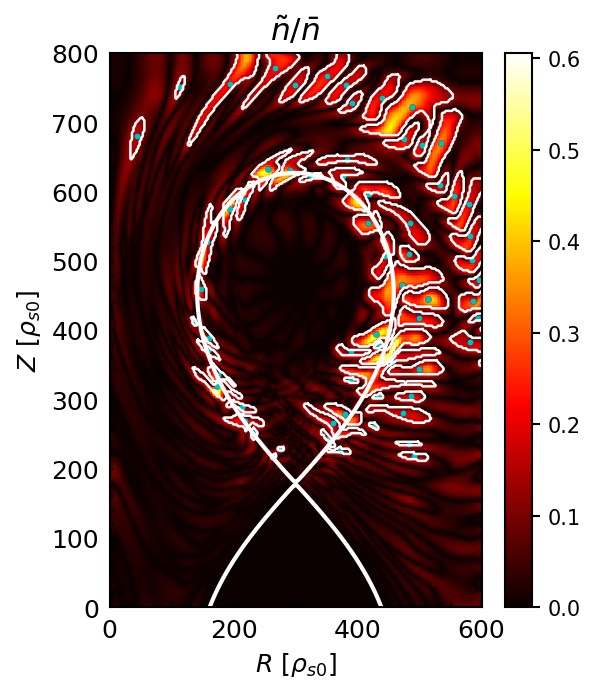

In [6]:
from skimage import measure
from skimage.measure import label, regionprops, find_contours

X,Y = np.meshgrid(s.x, s.y)
    
# Visualize each contour on the original plot
fig, ax = plt.subplots(figsize=(4, 4.8), dpi=150)



#Choose a threshold level (20 or 30% fluctuation)
cst=2.5
threshold = 0.2* np.max(dens_fluct_avg)
binary_image = dens_fluct_avg > threshold
#binary_image = dens_fluct_avg > dens_avg + cst*dens_std

# Label the regions in the binary image
labeled_image = label(binary_image)

# Find contours using the skimage measure module
contours = measure.find_contours(binary_image.astype(float), 0.5)  # Use 0.5 since binary image is either 0 or 1


areas = []
perimeters = []
# Calculate properties of each region
for region in regionprops(labeled_image):
    # The area of the region in pixels
    area = region.area
    areas.append(area)

    # The centroid coordinates of the region
    centroid = region.centroid

    # The perimeter of the region in pixels
    perimeter = region.perimeter

    
for region in regionprops(labeled_image):
    Y0, X0 = region.centroid
    ax.plot(cst*X0, cst*Y0, 'co', markersize=3, mew=0.1)  #

    # The length of the minor and major axis
    minor_axis_length = region.minor_axis_length
    major_axis_length = region.major_axis_length

    # The orientation of the ellipse
    orientation = region.orientation

    # Get the end points of the major axis
    X_major_axis_end1 = X0 + np.cos(orientation) * 0.5 * major_axis_length
    Y_major_axis_end1 = Y0 - np.sin(orientation) * 0.5 * major_axis_length
    X_major_axis_end2 = X0 - np.cos(orientation) * 0.5 * major_axis_length
    Y_major_axis_end2 = Y0 + np.sin(orientation) * 0.5 * major_axis_length

    # Get the end points of the minor axis
    X_minor_axis_end1 = X0 + np.sin(orientation) * 0.5 * minor_axis_length
    Y_minor_axis_end1 = Y0 + np.cos(orientation) * 0.5 * minor_axis_length
    X_minor_axis_end2 = X0 - np.sin(orientation) * 0.5 * minor_axis_length
    Y_minor_axis_end2 = Y0 - np.cos(orientation) * 0.5 * minor_axis_length

    # Plot the major axis
    #ax.plot([cst*X_major_axis_end1, cst*X_major_axis_end2],
    #        [cst*Y_major_axis_end1, cst*Y_major_axis_end2], 'b-')

    # Plot the minor axis
    #ax.plot([cst*X_minor_axis_end1, cst*X_minor_axis_end2],
    #        [cst*Y_minor_axis_end1, cst*Y_minor_axis_end2], 'b-')

    
# Size measurements
for region in regionprops(labeled_image):
    size_major = region.major_axis_length
    size_minor = region.minor_axis_length
    
    # The size can be considered as the product of the major and minor lengths (for an ellipse)
    # But, I will just calculate the area of contour...
    size = size_major * size_minor

    
cs = ax.pcolormesh(X, Y, dens_fluct_avg, cmap='hot')
#cs = ax.pcolormesh(X, Y, dens_DNT_avg, cmap='hot')
cbar = fig.colorbar(cs)
#cs5 = ax.pcolormesh(X, Y, right_outside_mask, cmap='binary_r', alpha=0.5)


# Plot the separatrix
ax.contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]], colors='w', linewidths=2)
# Plot each contour
for contour in contours:
    # Since dens_fluct_avg is (Y, X), contour[:, 0] is Y, and contour[:, 1] is X
    ax.plot(cst*contour[:, 1], cst*contour[:, 0], linewidth=1.2, c='w')  # No need to adjust contour plotting orientation

# Set the axes labels
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=12, width=0.8, size=2, pad=5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=12)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=12, rotation=90)
ax.set_title(r'$\tilde{n}/\bar{n}$', fontsize=15)
ax.set_xlim([0,600]); ax.set_ylim([0,800])

plt.show()

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Applying the mask in the SOL region </b></span><br>
</div>

/tmp/ipykernel_3713662/3154240721.py:6: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  mask_bottom = mask_contour.collections[0].get_paths()[0]


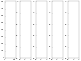

In [7]:
## NT 
fig, axes = plt.subplots(ncols=5,  figsize=(8, 6),  dpi=10, constrained_layout=True) 

mask_contour=axes[0].contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]],colors='w')

mask_bottom = mask_contour.collections[0].get_paths()[0]
#mask_top    = mask_contour.collections[0].get_paths()[1]
#mask_center = mask_contour.collections[0].get_paths()[2]

# Create a mask for points inside the contour path
inside_mask_bottom = mask_bottom.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
#inside_mask_top    = mask_top.contains_points(np.column_stack([X.ravel(), Y.ravel()]))
#inside_mask_center = mask_center.contains_points(np.column_stack([X.ravel(), Y.ravel()]))

inside_mask_bottom = inside_mask_bottom.reshape(X.shape)
#inside_mask_top    = inside_mask_top.reshape(X.shape)
#inside_mask_center = inside_mask_center.reshape(X.shape)


# For left and right part
#outside_mask = ~inside_mask_center_DNT & ~inside_mask_top & ~inside_mask_bottom
outside_mask = ~inside_mask_bottom

# Get the X coordinates that are to the left of the center region
left_outside_mask = outside_mask & (X < s.x[ixxpt])
right_outside_mask = outside_mask & (X > s.x[ixxpt])

# Reshape this mask to the original shape if necessary
left_outside_mask = left_outside_mask.reshape(X.shape)
right_outside_mask = right_outside_mask.reshape(X.shape)

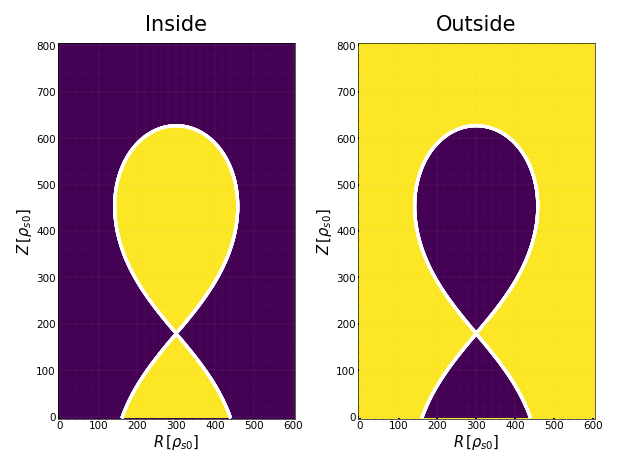

In [14]:
X, Y = np.meshgrid(s.x, s.y)
fig, axes = plt.subplots(nrows=1, ncols=2,  figsize=(4, 3),  dpi=150, constrained_layout=True) 


# Plot the figure
cs1 = axes[0].pcolormesh(X, Y, inside_mask_bottom, cmap='viridis')
cs2 = axes[1].pcolormesh(X, Y, outside_mask, cmap='viridis')

# Flatten the axes array for easy iteration
axes_flat = axes.flatten()

# The following indexing assumes that the order of plotting matches the flattening order of the axes
# Plot the pcolormesh for each subplot
pcolormeshes = [inside_mask_bottom, outside_mask]

titles = ['Inside', 'Outside']

for i in range(5):
    axes[0].contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]], colors='w')
    axes[1].contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]], colors='w')


for ax, data, title in zip(axes_flat, pcolormeshes, titles):
    cs = ax.pcolormesh(X, Y, data, cmap='viridis')
    ax.set_title(title, fontsize=10)
    ax.grid(True, which='major', alpha=1., linestyle=':', linewidth=0.1)
    ax.grid(True, which='minor', alpha=0.4, linestyle=':', linewidth=0.1)
    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis='x', labelsize=5, pad=1)
    ax.tick_params(axis='y', labelsize=5, pad=1)
    ax.tick_params(which='minor', direction="in", size=0.2)
    ax.tick_params(which='major', direction="in", size=0.5)
    ax.spines["bottom"].set_linewidth(0.3)
    ax.spines["left"].set_linewidth(0.3)
    ax.spines["right"].set_linewidth(0.3)
    ax.spines["top"].set_linewidth(0.3)
    ax.set_xlabel(r'$R \,[\rho_{s0}]$', fontsize=7, labelpad=1)
    ax.set_ylabel(r'$Z\, [\rho_{s0}]$', fontsize=7, rotation=90, labelpad=1)

# Show the plot
plt.show()

<div class="alert alert-block alert-info">
<span style="font-size: 26px;"><b>Consider only blobs within the masked region </b></span><br>
</div>

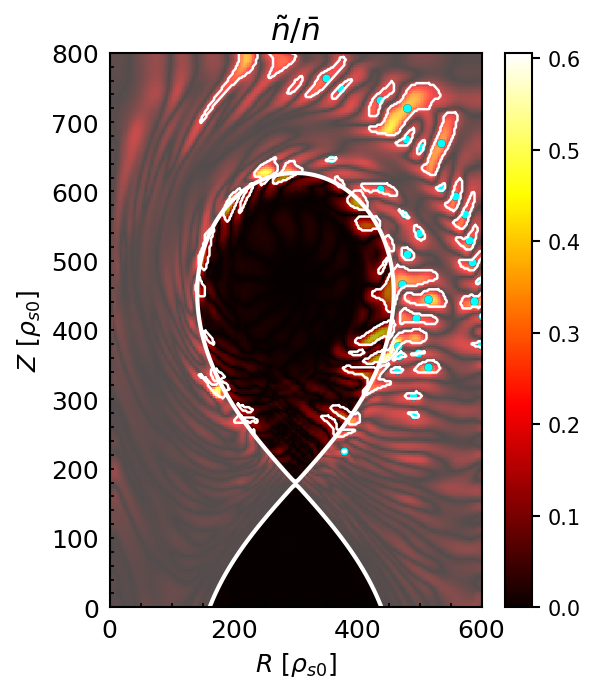

In [23]:
import skimage
from skimage.measure import label, regionprops, find_contours

X,Y = np.meshgrid(s.x, s.y)
    
# Visualize each contour on the original plot
fig, ax = plt.subplots(figsize=(4, 4.8), dpi=150)

#Choose a threshold level 

## Option (1)
threshold = 0.3 * np.max(dens_fluct_avg)
binary_image = dens_fluct_avg > threshold

## Option (2)
#binary_image = dens_DNT_avg > dens_DNT_avg + 2.5*dens_DNT_std

# Label the regions in the binary image
labeled_image = label(binary_image)

# Find contours using the skimage measure module
contours = measure.find_contours(binary_image.astype(float), 0.5)  # Use 0.5 since binary image is either 0 or 1

Nb_blobs = 0
areas = []
perimeters = []
size=[]
# Calculate properties of each region
for region in regionprops(labeled_image):
    
    # The centroid coordinates of the region
    centroid = region.centroid

    # The perimeter of the region in pixels
    perimeter = region.perimeter
    

    # The centroid coordinates (note the inversion of x and y for plotting)
    Y0, X0 = region.centroid
        
    # Convert centroid coordinates to indices
    X0_idx, Y0_idx = int(X0), int(Y0)

    # Check if the centroid is within the right side region
    if right_outside_mask[Y0_idx, X0_idx]:
        Nb_blobs += 1
        # This centroid is inside the right side region, so plot it
        ax.plot(cst*X0, cst*Y0, 'o', c='cyan', markersize=4, mew=0.1, mec='k')  # plot the centroid in blue
        
        # Calculate and store the area and perimeter if needed
        areas.append(region.area)
        perimeters.append(region.perimeter)
        
        size.append(region.major_axis_length * region.minor_axis_length)

    # The length of the minor and major axis
    minor_axis_length = region.minor_axis_length
    major_axis_length = region.major_axis_length

    # The orientation of the ellipse
    orientation = region.orientation

    # Get the end points of the major axis
    X_major_axis_end1 = X0 + np.cos(orientation) * 0.5 * major_axis_length
    Y_major_axis_end1 = Y0 - np.sin(orientation) * 0.5 * major_axis_length
    X_major_axis_end2 = X0 - np.cos(orientation) * 0.5 * major_axis_length
    Y_major_axis_end2 = Y0 + np.sin(orientation) * 0.5 * major_axis_length

    # Get the end points of the minor axis
    X_minor_axis_end1 = X0 + np.sin(orientation) * 0.5 * minor_axis_length
    Y_minor_axis_end1 = Y0 + np.cos(orientation) * 0.5 * minor_axis_length
    X_minor_axis_end2 = X0 - np.sin(orientation) * 0.5 * minor_axis_length
    Y_minor_axis_end2 = Y0 - np.cos(orientation) * 0.5 * minor_axis_length

    # Plot the major axis
    #ax.plot([cst*X_major_axis_end1, cst*X_major_axis_end2],
    #        [cst*Y_major_axis_end1, cst*Y_major_axis_end2], 'b-')

    # Plot the minor axis
    #ax.plot([cst*X_minor_axis_end1, cst*X_minor_axis_end2],
    #        [cst*Y_minor_axis_end1, cst*Y_minor_axis_end2], 'b-')

    

# Velocity of the blobs

cs = ax.pcolormesh(X, Y, dens_fluct_avg, cmap='hot', vmin=0, vmax=np.max(dens_fluct_avg))
cbar = fig.colorbar(cs)
cs5 = ax.pcolormesh(X, Y, outside_mask, cmap='binary_r', alpha=0.3)

# Plot the separatrix
ax.contour(X, Y, Psi, levels=[Psi[iyxpt, ixxpt]], colors='w', linewidths=2)
# Plot each contour
for contour in contours:
    # Since dens_fluct_avg is (Y, X), contour[:, 0] is Y, and contour[:, 1] is X
    ax.plot(cst*contour[:, 1], cst*contour[:, 0], linewidth=1.2, c='w')  # No need to adjust contour plotting orientation

# Set the axes labels
ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(which='both', direction='in', labelsize=12, width=0.8, size=2, pad=5)
ax.set_xlabel(r'$R\,\,[\rho_{s0}]$', fontsize=12)
ax.set_ylabel(r'$Z\,\,[\rho_{s0}]$', fontsize=12, rotation=90)
ax.set_title(r'$\tilde{n}/\bar{n}$', fontsize=15)
ax.set_xlim([0,600]); ax.set_ylim([0,800])

plt.show()